# Titanic

In [1]:
# DATA LIB
import pandas as pd
import numpy as np
import sklearn as sk

# TOOLS
import os
import re

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='white', context='notebook')
sns.set(rc={'figure.figsize':(9, 7)})

# MISC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
df_train = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')
df_test = pd.read_csv('~/.kaggle/competitions/titanic/test.csv')
df_all = pd.concat([df_train, df_test])


In [3]:
# View Data
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


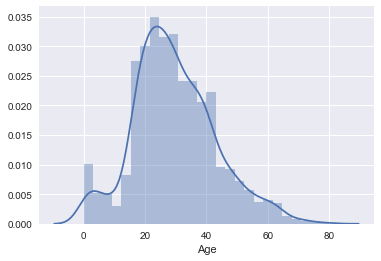

In [4]:
# Age

# Fill N/A w/fake data
age_avg = df_all['Age'].mean()
age_std = df_all['Age'].std()
fake_ages = np.random.randint(age_avg - age_std, age_avg + age_std, size=df_all['Age'].isnull().sum())
df_all['Age'][np.isnan(df_all['Age'])] = fake_ages
df_all['Age'] = df_all['Age'].astype(int)

# Bin Ages
df_all['AgeBin'] = pd.cut(df_all['Age'], 5, labels=[0, 1, 2, 3, 4])

# Plot
_ = sns.distplot(df_all['Age'].astype(float))

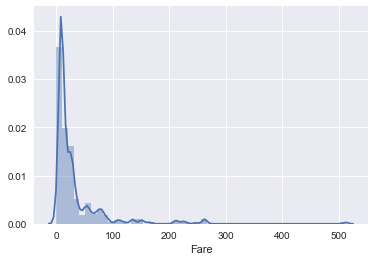

In [5]:
# Fare

# Fill N/A
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].median())

# Bin Ages
df_all['FareBin'] = pd.qcut(df_all['Fare'], 6, labels=[0, 1, 2, 3, 4, 5])

# Plot
_ = sns.distplot(df_all['Fare'].astype(float))

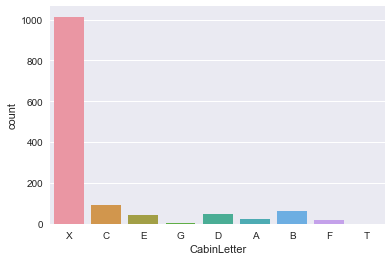

In [6]:
# Cabin

# Cabin Prefix
df_all['CabinLetter'] = df_all['Cabin'].apply(lambda x: 'X' if type(x) == float else x[0])
cabin_dummies = pd.get_dummies(df_all['CabinLetter'], prefix='Cabin').astype(int)
df_all = pd.concat([df_all, cabin_dummies], axis=1)

# Plot Cabins
_ = sns.countplot(df_all['CabinLetter'])

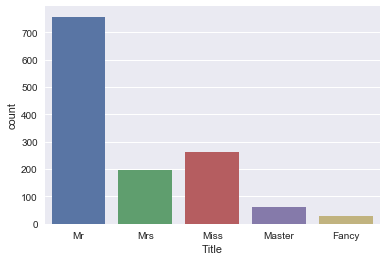

In [7]:
# Name

# Title
def extract_title(name):
    
    re_title = re.search(' ([A-Za-z]+)\.', name)
    
    if not re_title:
        return ''
    else:
        title = re_title.group(1)
        
    if title in ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Fancy'
    elif title in ['Mlle', 'Ms', 'Miss']:
        return 'Miss'
    elif title in ['Mme', 'Mrs']:
        return 'Mrs'
    else:
        return title
    
df_all['Title'] = df_all['Name'].apply(extract_title)
title_dummies = pd.get_dummies(df_all['Title'], prefix='Title').astype(int)
df_all = pd.concat([df_all, title_dummies], axis=1)

# Plot Title
_ = sns.countplot(df_all['Title'])

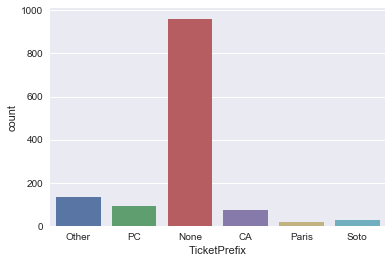

In [8]:
# Ticket

# Ticket Prefix
def extract_prefix(ticket):
    
    re_ticket = re.search('([\w/\.]+) \d+', ticket)
    
    if not re_ticket:
        return 'None'
    else:
        prefix = re_ticket.group(1)
        
    ticket = prefix.strip().replace("/", "").replace(".", "").lower()
    
    if "paris" in ticket:
        return "Paris"
    elif "soto" in ticket:
        return "Soto"
    elif "pc" in ticket:
        return "PC"
    elif "ca" in ticket:
        return "CA"
    elif len(ticket) == 2 and ticket[0] == "A":
        return "A"
    else:
        return "Other"
    

df_all['TicketPrefix'] = df_all['Ticket'].apply(extract_prefix)
# df_all['TicketHasPrefix'] = df_all['TicketPrefix'].apply(lambda x: 0 if x == "" else 1)
ticket_dummies = pd.get_dummies(df_all['TicketPrefix'], prefix='TicketType').astype(int)
df_all = pd.concat([df_all, ticket_dummies], axis=1)

# Plot Ticket
_ = sns.countplot(df_all['TicketPrefix'])

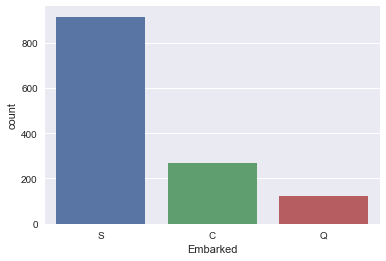

In [9]:
# Embarked

# Fix Missing
df_all['Embarked'] = df_all['Embarked'].fillna(df_all['Embarked'].mode())

# Dummy Vars
embark_dummies = pd.get_dummies(df_all['Embarked'], prefix='Embark').astype(int)
df_all = pd.concat([df_all, embark_dummies], axis=1)

# Plot Embark
_ = sns.countplot(df_all['Embarked'])

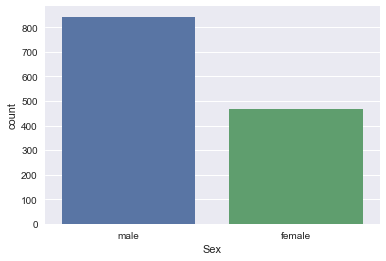

In [10]:
# Sex

# Map to 0/1
df_all['SexType'] = df_all['Sex'].map({'female': 0, 'male': 1}).astype(int)

# Plot Sex
_ = sns.countplot(df_all['Sex'])

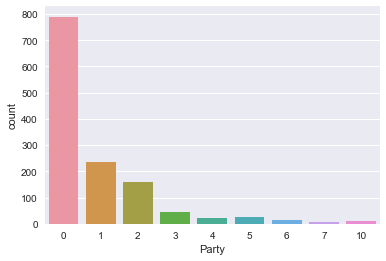

In [11]:
# Pclass and SibSp

# Traveling Party
df_all['Party'] = df_all['SibSp'] + df_all['Parch']
df_all['Alone'] = df_all['Party'].apply(lambda x: x == 0)

# Plot Party
_ = sns.countplot(df_all['Party'])

In [12]:
# Drop Extra Columns

drop_cols = ['PassengerId', 'Age', 'Cabin', 'CabinLetter', 'Embarked', 'Sex', 'Fare', 'Name', 'Title', 'Ticket', 'TicketPrefix']
df_feat = df_all.drop(drop_cols, axis=1)

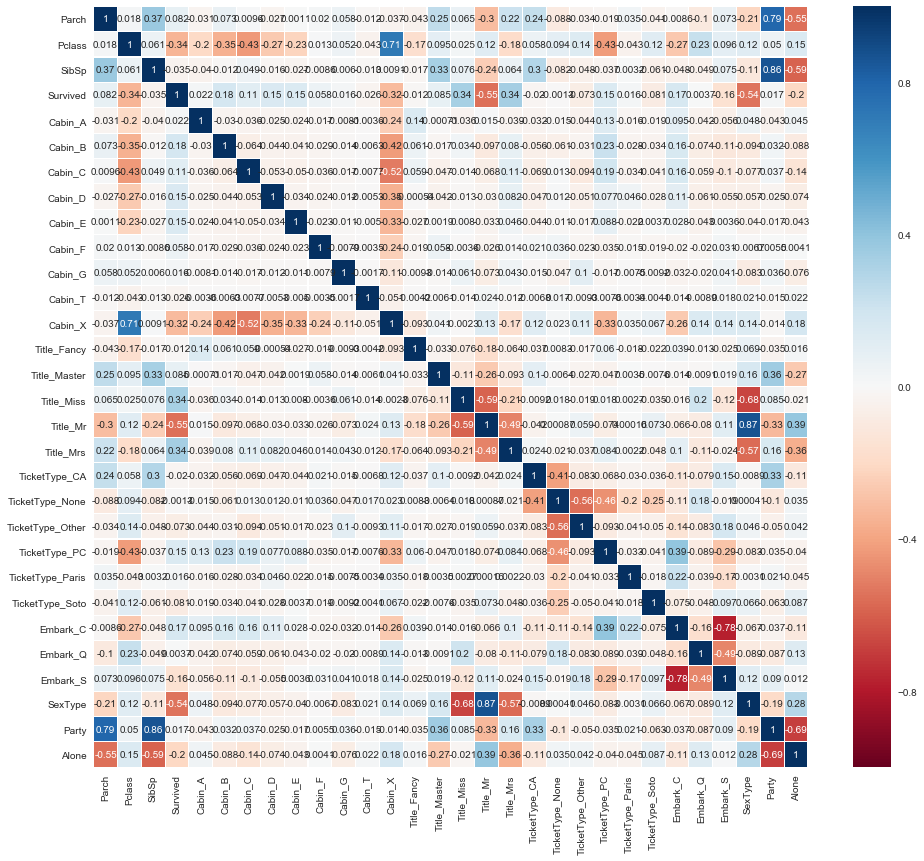

In [14]:
# Show Correlation

plt.figure(figsize=(16,14))
_ = sns.heatmap(df_feat.corr(), cmap=plt.cm.RdBu, linewidths=0.1, vmin=-1.0, vmax=1.0, annot=True)

In [15]:
# Modeling (Inspired By https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [16]:
# Split/Process Data

num_train = len(df_train)

x_cols = ['Parch', 'Pclass', 'SibSp', 'AgeBin', 'FareBin', 'Cabin_A',
           'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
           'Cabin_T', 'Cabin_X', 'Title_Fancy', 'Title_Master',
           'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Embark_C',
           'Embark_Q', 'Embark_S', 'SexType', 'Party', 'Alone',
           'TicketType_CA', 'TicketType_None', 'TicketType_Other', 'TicketType_PC', 'TicketType_Paris']

x_all = df_feat[x_cols].as_matrix()
y_all = df_feat['Survived'].as_matrix()

X_train, X_test = x_all[:num_train], x_all[num_train:]
Y_train = y_all[:num_train]

kfold = StratifiedKFold(n_splits=10)


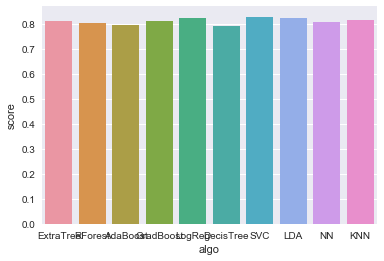

In [17]:
# Models

rand_num = 22

clfs = {
    "SVC":       SVC(random_state=rand_num),
    "DecisTree": DecisionTreeClassifier(random_state=rand_num),
    "AdaBoost":  AdaBoostClassifier(DecisionTreeClassifier(random_state=rand_num), random_state=rand_num, learning_rate=0.1),
    "RForest":   RandomForestClassifier(random_state=rand_num),
    "ExtraTree": ExtraTreesClassifier(random_state=rand_num),
    "GradBoost": GradientBoostingClassifier(random_state=rand_num),
    "NN":        MLPClassifier(random_state=rand_num),
    "KNN":       KNeighborsClassifier(),
    "LogReg":    LogisticRegression(random_state=rand_num),
    "LDA":       LinearDiscriminantAnalysis()
}

results = []

for algo, model in clfs.items():
    
    result = cross_val_score(model, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=-1)
    results.append({'algo': algo, 'score': result.mean(), 'stddev': result.std()})
    
results = pd.DataFrame(results)

_ = sns.barplot(x="algo", y="score", data=results)

In [18]:
# Hype Tuneing

rand_num = 77

grid_extratree = {"max_depth": [None],
                  "max_features": [1, 3, 10],
                  "min_samples_split": [2, 3, 10],
                  "min_samples_leaf": [1, 3, 10],
                  "bootstrap": [False],
                  "n_estimators" :[100, 300],
                  "criterion": ["gini"]}

grid_rforest = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False],
                "n_estimators" :[100, 300],
                "criterion": ["gini"]}

grid_gradboost = {'loss' : ["deviance"],
                  'n_estimators' : [100, 200, 300],
                  'learning_rate': [0.1, 0.05, 0.01],
                  'max_depth': [4, 8],
                  'min_samples_leaf': [100,150],
                  'max_features': [0.3, 0.1]}

grid_svc = {'kernel': ['rbf'], 
            'gamma': [ 0.001, 0.01, 0.1, 1],
            'C': [1, 10, 50, 100, 200, 300, 1000]}

grid_lda = {}

grid_logreg = {'penalty': ['l1', 'l2'],
               'C': [1, 10, 50, 100, 200, 300, 1000]}

best_clfs = {
    "ExtraTree": {"model": ExtraTreesClassifier(), "grid": grid_extratree},
    "RForest":   {"model": RandomForestClassifier(), "grid": grid_rforest},
    "GradBoost": {"model": GradientBoostingClassifier(), "grid": grid_gradboost},
    "SVC":       {"model": SVC(probability=True), "grid": grid_svc},
    "LDA":       {"model": LinearDiscriminantAnalysis(), "grid": grid_lda},
    "LogReg":    {"model": LogisticRegression(random_state=rand_num), "grid": grid_logreg}  
}

for algo, data in best_clfs.items():
    
    grid_search = GridSearchCV(data["model"], param_grid=data["grid"], cv=kfold, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train,Y_train)
    
    data["best"] = grid_search.best_estimator_
    
    print(algo, grid_search.best_score_)


ExtraTree 0.832772166105
RForest 0.833894500561
LDA 0.821548821549
GradBoost 0.821548821549
LogReg 0.827160493827
SVC 0.83164983165


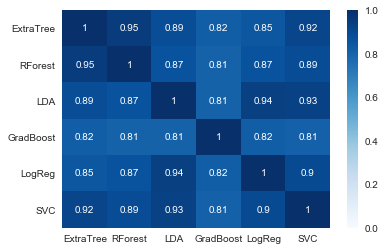

In [19]:
# Model Correlation

test_results = []

for algo, data in best_clfs.items():
    
    test_results.append(pd.Series(data["best"].predict(X_test), name=algo))
    
test_results = pd.concat(test_results, axis=1)

_ = sns.heatmap(test_results.corr(), cmap=plt.cm.Blues, vmin=0, vmax=1.0, annot=True)


In [22]:
# Voting

estimators = [(algo, data["best"]) for algo, data in best_clfs.items()]

voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=4)

voting_clf = voting_clf.fit(X_train, Y_train)

In [21]:
# Save Results

survived = pd.Series(voting_clf.predict(X_test), name="Survived")

output = pd.concat([df_test['PassengerId'], survived.astype(int)], axis=1)
output.to_csv("output.csv", index=False)